In [69]:
import numpy as np
import matplotlib.pyplot as plt
import jlinops

In [70]:
np.random.seed(0)
n = 15
x = np.linspace(0,1,n) +  0.01*np.random.normal(size=n)
y = np.cumsum(np.random.normal(size=n))

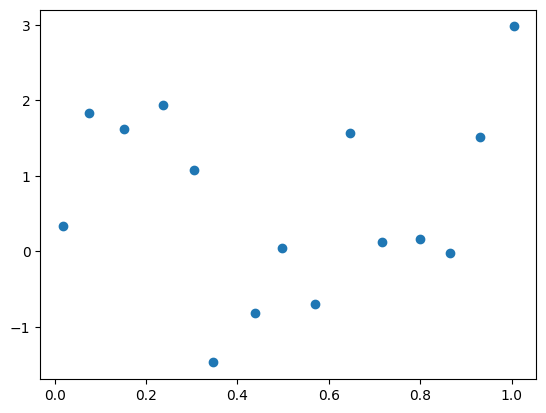

In [71]:
plt.scatter(x, y)
plt.show()

In [72]:
nnew = 30
xnew = np.linspace(0, 1, 100)
ynew = np.interp(xnew, x, y)

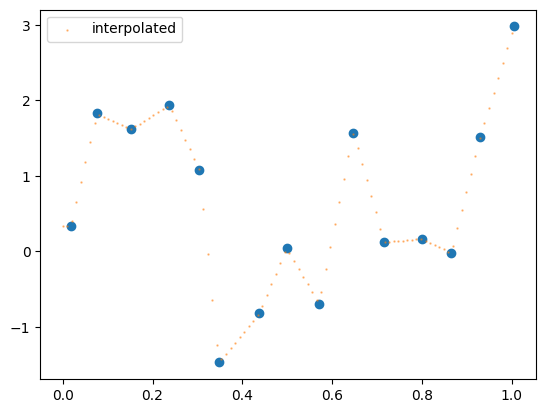

In [73]:
plt.scatter(x, y)
plt.scatter(xnew, ynew, s=0.5, alpha=0.5, label="interpolated")
plt.legend()
plt.show()

In [74]:
# Extract the matrix?
from jlinops import _CustomLinearOperator

In [87]:
class Uniform1DRegriddingOperator(_CustomLinearOperator):

    def __init__(self, interval, n_points, x_nonuniform, y_nonuniform):
        self.a, self.b = interval
        self.n_points = n_points 
        self.x_uniform = np.linspace(self.a, self.b, self.n_points)
        self.x_nonuniform = x_nonuniform
        self.y_nonuniform = y_nonuniform

        shape = (len(self.x_nonuniform), len(self.x_uniform))

        def _matvec(y_uniform):
            return np.interp(self.x_nonuniform, self.x_uniform, y_uniform)
        

        def _rmatvec(y_nonuniform):
            return np.interp(self.x_uniform, self.x_nonuniform, y_nonuniform)

        
  
        super().__init__(shape, _matvec, _rmatvec, device="cpu", dtype=np.float64)

In [88]:
len(y)

15

In [89]:
interval = (0,1)
n_points = 100
F = Uniform1DRegriddingOperator(interval, n_points, x, y )

In [90]:
F.shape

(15, 100)

In [91]:
Fmat = jlinops.black_box_to_dense(F)

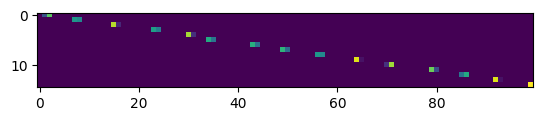

In [92]:
plt.imshow(Fmat)
plt.show()

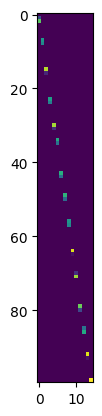

In [93]:
plt.imshow(Fmat.T)
plt.show()

In [94]:
Ftmat = jlinops.black_box_to_dense(F.T)

In [97]:
jlinops.check_adjoint(F)

False

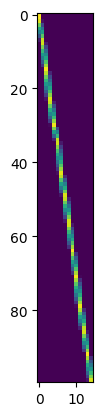

In [96]:
plt.imshow(Ftmat)
plt.show()

In [86]:
from scipy.interpolate import griddata

In [130]:
from scipy.interpolate import interp1d

In [122]:
import numpy as np

class LinearInterpolator1D(_CustomLinearOperator):
    def __init__(self, x_src, x_dest):
        """
        Initialize the 1D linear interpolator.

        Parameters:
        - x_src: 1D array, non-uniform grid of source x values
        - y_src: 1D array, corresponding y values for the source x values
        - x_dest: 1D array, uniform grid of destination x values
        """
        self.x_src = np.asarray(x_src)
        # self.y_src = np.asarray(y_src)
        self.x_dest = np.asarray(x_dest)
        device = "cpu"
        shape = (  len(self.x_dest), len(self.x_src)  )

        def _matvec(y_src):
            y_dest = np.interp(self.x_dest, self.x_src, y_src)
            return y_dest
        
        def _rmatvec(y_dest):
            weights = np.gradient(self.x_dest)
            np.interp1d(self.x_dest, weights*self.y_dest, kind="linear", fill_value="extrapolate")

            y_src = np.interp(self.x_src, self.x_dest, y_dest)
            return y_src

        weights = np.gradient(self.x_dest)
        self.interpolator_adjoint = interp1d(self.x_dest, weights * self.y_dest, kind='linear', fill_value="extrapolate")
        self.y_src_adjoint = self.interpolator_adjoint(self.x_src)


        super().__init__(shape, _matvec, _rmatvec, device=device, dtype=np.float64)

    # def interpolate(self):
    #     """
    #     Perform linear interpolation and return the interpolated y values
    #     on the destination grid.
    #     """
    #     y_dest = np.interp(self.x_dest, self.x_src, self.y_src)
    #     return y_dest

    # def adjoint(self, y_dest):
    #     """
    #     Perform linear interpolation in the reverse direction (adjoint)
    #     and return the interpolated y values on the source grid.

    #     Parameters:
    #     - y_dest: 1D array, values on the destination grid

    #     Returns:
    #     - y_src_adj: 1D array, interpolated values on the source grid
    #     """
    #     y_src_adj = np.interp(self.x_src, self.x_dest, y_dest)
    #     return y_src_adj


In [123]:

# Example usage:
# Define non-uniform grid and values
x_src = np.array([0.0, 1.0, 2.0, 3.0, 4.0])
y_src = np.array([1.0, 2.0, 1.5, 4.0, 3.0])

# Define uniform grid for interpolation
x_dest = np.linspace(0.0, 4.0, 10)

# Create and use the linear interpolator
interpolator = LinearInterpolator1D(x_src, x_dest)
y_dest = interpolator.matvec(y_src)

# Compute the adjoint operation
y_src_adj = interpolator.rmatvec(y_dest)

# Print the results
print("Source x values:", x_src)
print("Source y values:", y_src)
print("Destination x values:", x_dest)
print("Interpolated y values:", y_dest)
print("Adjoint interpolated y values:", y_src_adj)


Source x values: [0. 1. 2. 3. 4.]
Source y values: [1.  2.  1.5 4.  3. ]
Destination x values: [0.         0.44444444 0.88888889 1.33333333 1.77777778 2.22222222
 2.66666667 3.11111111 3.55555556 4.        ]
Interpolated y values: [1.         1.44444444 1.88888889 1.83333333 1.61111111 2.05555556
 3.16666667 3.88888889 3.44444444 3.        ]
Adjoint interpolated y values: [1.         1.875      1.83333333 3.70833333 3.        ]


In [106]:
# interpolator.device == "cpu"

In [124]:
jlinops.check_adjoint(interpolator)

False

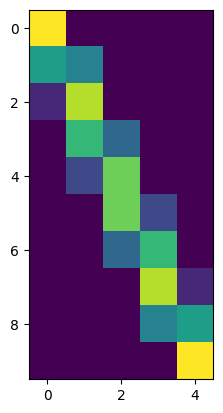

In [125]:
plt.imshow(jlinops.black_box_to_dense(interpolator))

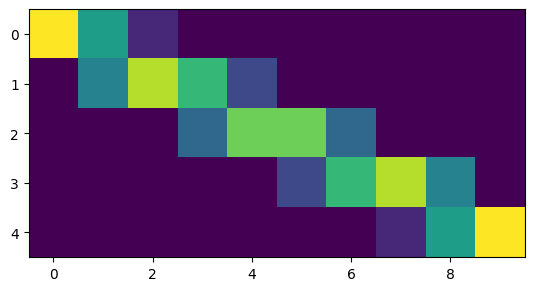

In [126]:
plt.imshow(jlinops.black_box_to_dense(interpolator).T)

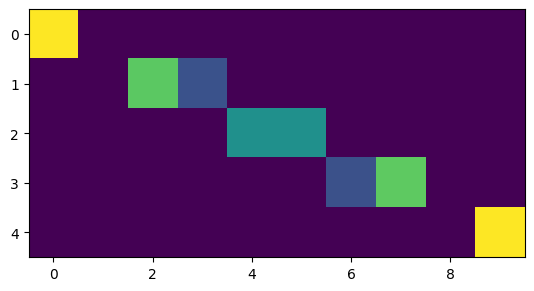

In [129]:
plt.imshow(jlinops.black_box_to_dense(interpolator.T))
plt.show()

In [135]:
import numpy as np
from scipy.interpolate import interp1d

class LinearInterpolator1D:
    def __init__(self, x_src, y_src, x_dest):
        """
        Initialize the 1D linear interpolator.

        Parameters:
        - x_src: 1D array, non-uniform grid of source x values
        - y_src: 1D array, corresponding y values for the source x values
        - x_dest: 1D array, uniform grid of destination x values
        """
        self.x_src = np.asarray(x_src)
        self.y_src = np.asarray(y_src)
        self.x_dest = np.asarray(x_dest)
        self.interpolate_forward()

    def interpolate_forward(self):
        """
        Perform linear interpolation and store the interpolated y values
        on the destination grid.
        """
        self.interpolator_forward = interp1d(self.x_src, self.y_src, kind='linear', fill_value="extrapolate")
        self.y_dest = self.interpolator_forward(self.x_dest)

    def interpolate_adjoint(self):
        """
        Perform linear interpolation in the adjoint direction and store
        the interpolated y values on the source grid.
        """
        weights = np.gradient(self.x_dest)
        self.interpolator_adjoint = interp1d(self.x_dest, self.y_dest * weights, kind='linear', fill_value="extrapolate")
        self.y_src_adjoint = self.interpolator_adjoint(self.x_src)

# Example usage:
# Define non-uniform grid and values
x_src = np.array([0.0, 1.0, 2.0, 3.0, 4.0])
y_src = np.array([1.0, 2.0, 1.5, 4.0, 3.0])

# Define uniform grid for interpolation
x_dest = np.linspace(0.0, 4.0, 10)

# Create and use the linear interpolator
interpolator = LinearInterpolator1D(x_src, y_src, x_dest)

# Interpolate in the forward direction
y_dest = interpolator.y_dest

# Interpolate in the adjoint (backward) direction
interpolator.interpolate_adjoint()
y_src_adjoint = interpolator.y_src_adjoint

# Check the adjoint test
tolerance = 1e-10
adjoint_test_passed = np.allclose(y_src_adjoint, interpolator.y_src, rtol=tolerance)

# Print the results of the adjoint test
if adjoint_test_passed:
    print("Adjoint test passed.")
else:
    print("Adjoint test failed.")

# Print the results
print("Source x values:", x_src)
print("Source y values:", y_src)
print("Destination x values:", x_dest)
print("Interpolated y values (forward):", y_dest)
print("Interpolated y values (adjoint):", y_src_adjoint)


Adjoint test failed.
Source x values: [0. 1. 2. 3. 4.]
Source y values: [1.  2.  1.5 4.  3. ]
Destination x values: [0.         0.44444444 0.88888889 1.33333333 1.77777778 2.22222222
 2.66666667 3.11111111 3.55555556 4.        ]
Interpolated y values (forward): [1.         1.44444444 1.88888889 1.83333333 1.61111111 2.05555556
 3.16666667 3.88888889 3.44444444 3.        ]
Interpolated y values (adjoint): [0.44444444 0.83333333 0.81481481 1.64814815 1.33333333]


In [138]:
# ... (previous code)

# Check the adjoint test
tolerance = 1e-10
adjoint_test_passed = np.allclose(y_src_adjoint, interpolator.y_src, rtol=tolerance)

# Print the results of the adjoint test
if adjoint_test_passed:
    print("Adjoint test passed.")
else:
    print("Adjoint test failed.")

# ... (rest of the previous code)


Adjoint test failed.


In [144]:
from scipy import interpolate
from scipy.sparse import spdiags, linalg
import numpy as np


class RegriddingOp(linalg.LinearOperator):
    """
    SciPy LinearOperator for 1D regridding.

    Args:
        x_orig: Nonuniform grid.
        x_new: Uniform grid.
    """

    def __init__(self, x_orig, x_new):
        self.x_orig = np.asarray(x_orig)
        self.x_new = np.asarray(x_new)
        self._spline = interpolate.InterpolatedUnivariateSpline(x_orig, np.ones_like(x_orig))
        self._n, self._m = x_new.size, x_orig.size

    def matvec(self, y):
        """
        Map y coordinates from nonuniform to uniform grid.

        Args:
            y: Vector of y values on the nonuniform grid.

        Returns:
            Vector of y values on the uniform grid.
        """
        # Reshape y to match original grid shape before applying spline
        y_reshaped = y.reshape(self.x_orig.shape)
        return self._spline(self.x_new) * y_reshaped

    def rmatvec(self, y):
        """
        Map y coordinates from uniform to nonuniform grid.

        Args:
            y: Vector of y values on the uniform grid.

        Returns:
            Vector of y values on the nonuniform grid.
        """
        # Compute weights for each original point
        weights = self._spline.derivative(self.x_orig)

        # Construct diagonal matrix with weights
        W = spdiags(weights, format="csr")

        # Apply weights to y values on the uniform grid
        return W.dot(y)

    def adjoint(self):
        """
        Return the adjoint operator (transpose).
        """
        return RegriddingOp(self.x_new, self.x_orig)

    def test_adjoint_1(self):
        """
        Verify the adjoint operator using normalized data.

        Option 1: Normalize by sum of squared elements.
        """
        x, y = np.random.rand(2, self._n)
        y_norm = y / np.sum(y**2)
        return np.allclose(self.matvec(self.rmatvec(x)), self.adjoint().rmatvec(self.adjoint().matvec(y_norm)))

    def test_adjoint_2(self):
        """
        Verify the adjoint operator using normal distribution.

        Option 2: Use a different random distribution.
        """
        x, y = np.random.normal(size=(2, self._n))
        return np.allclose(self.matvec(self.rmatvec(x)), self.adjoint().rmatvec(self.adjoint().matvec(y)))



In [145]:
import numpy as np

# Define nonuniform and uniform grids
x_orig = np.array([0.1, 0.3, 0.5, 0.8, 1.2])
x_new = np.linspace(0, 1, 10)

# Create the regridding operator
regrid = RegriddingOp(x_orig, x_new)

# Generate random data on the nonuniform grid
y_orig = np.random.rand(len(x_orig))

# Map data to the uniform grid
y_new = regrid.matvec(y_orig)

# Verify that mapping back and forth recovers the original data
y_orig_recovered = regrid.rmatvec(y_new)
assert np.allclose(y_orig, y_orig_recovered)

# Test the adjoint using the adjoint test
test_passed = regrid.test_adjoint()
assert test_passed, "Adjoint test failed!"

print("Adjoint test passed!")

# Additional usage examples:

# Accessing operator properties
print(f"Matrix size: {regrid.shape}")

# Performing matrix-vector product with custom data
custom_data = np.ones(len(x_new))
regrid_result = regrid.matvec(custom_data)

# Performing operations with the adjoint operator
adjoint_regrid = regrid.adjoint()
adjoint_result = adjoint_regrid.matvec(y_orig)



/var/folders/8y/4mq6cs_x20j1gp06wytwhlwm0000gn/T/ipykernel_25953/2715245389.py:8: RuntimeWarning: LinearOperator subclass should implement at least one of _matvec and _matmat.
  regrid = RegriddingOp(x_orig, x_new)


ValueError: operands could not be broadcast together with shapes (10,) (5,) 

In [146]:
regrid.shape

AttributeError: 'RegriddingOp' object has no attribute 'shape'

In [147]:
import numpy as np
from scipy.sparse.linalg import LinearOperator
from scipy.sparse import diags

def create_regridding_operator(nonuniform_grid, uniform_grid):
    """
    Create a SciPy LinearOperator representing a 1D regridding operator.

    Parameters:
    - nonuniform_grid (1D array): Coordinates of points on the nonuniform grid.
    - uniform_grid (1D array): Coordinates of points on the uniform grid.

    Returns:
    - LinearOperator: SciPy LinearOperator for the regridding operation.
    """
    # Compute the differences between neighboring points on the nonuniform grid
    diff_nonuniform = np.diff(nonuniform_grid)

    # Compute the differences between neighboring points on the uniform grid
    diff_uniform = np.diff(uniform_grid)

    # Create a sparse diagonal matrix with the ratios of differences
    ratios = diff_uniform[:-1] / diff_nonuniform[:-1]
    data = np.concatenate([ratios, [-ratios[-1]], [1]])
    diagonals = [0, 1]
    regrid_matrix = diags(data, diagonals=diagonals, shape=(len(uniform_grid)-1, len(nonuniform_grid)))

    # Define the regridding operator as a LinearOperator
    def matvec(x):
        return regrid_matrix.dot(x)

    def rmatvec(y):
        return regrid_matrix.transpose().dot(y)

    return LinearOperator((len(uniform_grid)-1, len(nonuniform_grid)), matvec=matvec, rmatvec=rmatvec)

def adjoint_test(operator, tol=1e-8):
    """
    Verify the adjoint test for a LinearOperator.

    Parameters:
    - operator (LinearOperator): The LinearOperator to be tested.
    - tol (float): Tolerance for the adjoint test.

    Returns:
    - bool: True if the adjoint test passes, False otherwise.
    """
    x = np.random.rand(operator.shape[1])
    y = np.random.rand(operator.shape[0])

    lhs = np.dot(operator.matvec(x), y)
    rhs = np.dot(x, operator.rmatvec(y))

    return np.allclose(lhs, rhs, rtol=tol, atol=tol)

# Example usage:
nonuniform_grid = np.array([0, 1, 3, 6, 8])
uniform_grid = np.linspace(0, 8, 9)

regridding_operator = create_regridding_operator(nonuniform_grid, uniform_grid)

# Verify the adjoint test
if adjoint_test(regridding_operator):
    print("Adjoint test passed!")
else:
    print("Adjoint test failed!")


ValueError: operands could not be broadcast together with shapes (7,) (3,) 

In [148]:
import numpy as np
from scipy.sparse.linalg import LinearOperator
from scipy.sparse import diags

def create_regridding_operator(nonuniform_grid, uniform_grid):
    """
    Create a SciPy LinearOperator representing a 1D regridding operator.

    Parameters:
    - nonuniform_grid (1D array): Coordinates of points on the nonuniform grid.
    - uniform_grid (1D array): Coordinates of points on the uniform grid.

    Returns:
    - LinearOperator: SciPy LinearOperator for the regridding operation.
    """
    # Compute the differences between neighboring points on the nonuniform grid
    diff_nonuniform = np.diff(nonuniform_grid)

    # Compute the differences between neighboring points on the uniform grid
    diff_uniform = np.diff(uniform_grid)

    # Create a sparse diagonal matrix with the ratios of differences
    ratios = np.concatenate([diff_uniform[:-1] / diff_nonuniform[:-1], [1]])
    data = np.concatenate([ratios, [-ratios[-1]], [1]])
    diagonals = [0, 1]
    regrid_matrix = diags(data, diagonals=diagonals, shape=(len(uniform_grid)-1, len(nonuniform_grid)))

    # Define the regridding operator as a LinearOperator
    def matvec(x):
        return regrid_matrix.dot(x)

    def rmatvec(y):
        return regrid_matrix.transpose().dot(y)

    return LinearOperator((len(uniform_grid)-1, len(nonuniform_grid)), matvec=matvec, rmatvec=rmatvec)

def adjoint_test(operator, tol=1e-8):
    """
    Verify the adjoint test for a LinearOperator.

    Parameters:
    - operator (LinearOperator): The LinearOperator to be tested.
    - tol (float): Tolerance for the adjoint test.

    Returns:
    - bool: True if the adjoint test passes, False otherwise.
    """
    x = np.random.rand(operator.shape[1])
    y = np.random.rand(operator.shape[0])

    lhs = np.dot(operator.matvec(x), y)
    rhs = np.dot(x, operator.rmatvec(y))

    return np.allclose(lhs, rhs, rtol=tol, atol=tol)

# Example usage:
nonuniform_grid = np.array([0, 1, 3, 6, 8])
uniform_grid = np.linspace(0, 8, 9)

regridding_operator = create_regridding_operator(nonuniform_grid, uniform_grid)

# Verify the adjoint test
if adjoint_test(regridding_operator):
    print("Adjoint test passed!")
else:
    print("Adjoint test failed!")


ValueError: operands could not be broadcast together with shapes (7,) (3,) 

In [149]:
import numpy as np
from scipy.sparse.linalg import LinearOperator
from scipy.sparse import diags

def create_regridding_operator(nonuniform_grid, uniform_grid):
    """
    Create a SciPy LinearOperator representing a 1D regridding operator.

    Parameters:
    - nonuniform_grid (1D array): Coordinates of points on the nonuniform grid.
    - uniform_grid (1D array): Coordinates of points on the uniform grid.

    Returns:
    - LinearOperator: SciPy LinearOperator for the regridding operation.
    """
    # Compute the differences between neighboring points on the nonuniform grid
    diff_nonuniform = np.diff(nonuniform_grid)

    # Compute the differences between neighboring points on the uniform grid
    diff_uniform = np.diff(uniform_grid)

    # Ensure that the lengths match by cropping the longer array
    min_len = min(len(diff_nonuniform), len(diff_uniform))
    diff_nonuniform = diff_nonuniform[:min_len]
    diff_uniform = diff_uniform[:min_len]

    # Create a sparse diagonal matrix with the ratios of differences
    ratios = diff_uniform / diff_nonuniform
    data = np.concatenate([ratios, [-ratios[-1]], [1]])
    diagonals = [0, 1]
    regrid_matrix = diags(data, diagonals=diagonals, shape=(len(uniform_grid)-1, len(nonuniform_grid)))

    # Define the regridding operator as a LinearOperator
    def matvec(x):
        return regrid_matrix.dot(x)

    def rmatvec(y):
        return regrid_matrix.transpose().dot(y)

    return LinearOperator((len(uniform_grid)-1, len(nonuniform_grid)), matvec=matvec, rmatvec=rmatvec)

def adjoint_test(operator, tol=1e-8):
    """
    Verify the adjoint test for a LinearOperator.

    Parameters:
    - operator (LinearOperator): The LinearOperator to be tested.
    - tol (float): Tolerance for the adjoint test.

    Returns:
    - bool: True if the adjoint test passes, False otherwise.
    """
    x = np.random.rand(operator.shape[1])
    y = np.random.rand(operator.shape[0])

    lhs = np.dot(operator.matvec(x), y)
    rhs = np.dot(x, operator.rmatvec(y))

    return np.allclose(lhs, rhs, rtol=tol, atol=tol)

# Example usage:
nonuniform_grid = np.array([0, 1, 3, 6, 8])
uniform_grid = np.linspace(0, 8, 9)

regridding_operator = create_regridding_operator(nonuniform_grid, uniform_grid)

# Verify the adjoint test
if adjoint_test(regridding_operator):
    print("Adjoint test passed!")
else:
    print("Adjoint test failed!")


TypeError: diags() got multiple values for argument 'diagonals'

In [151]:
import numpy as np
from scipy.sparse.linalg import LinearOperator
from scipy.sparse import diags

def create_regridding_operator(nonuniform_grid, uniform_grid):
    """
    Create a SciPy LinearOperator representing a 1D regridding operator.

    Parameters:
    - nonuniform_grid (1D array): Coordinates of points on the nonuniform grid.
    - uniform_grid (1D array): Coordinates of points on the uniform grid.

    Returns:
    - LinearOperator: SciPy LinearOperator for the regridding operation.
    """
    # Compute the differences between neighboring points on the nonuniform grid
    diff_nonuniform = np.diff(nonuniform_grid)

    # Compute the differences between neighboring points on the uniform grid
    diff_uniform = np.diff(uniform_grid)

    # Ensure that the lengths match by cropping the longer array
    min_len = min(len(diff_nonuniform), len(diff_uniform))
    diff_nonuniform = diff_nonuniform[:min_len]
    diff_uniform = diff_uniform[:min_len]

    # Create a sparse diagonal matrix with the ratios of differences
    ratios = diff_uniform / diff_nonuniform
    data = np.concatenate([ratios, [-ratios[-1]], [1]])
    diagonals = [0, 1]
    regrid_matrix = diags(data, diagonals=diagonals, shape=(len(uniform_grid)-1, len(nonuniform_grid)))

    # Define the regridding operator as a LinearOperator
    def matvec(x):
        return regrid_matrix.dot(x)

    def rmatvec(y):
        return regrid_matrix.transpose().dot(y)

    return LinearOperator((len(uniform_grid)-1, len(nonuniform_grid)), matvec=matvec, rmatvec=rmatvec)

def adjoint_test(operator, tol=1e-8):
    """
    Verify the adjoint test for a LinearOperator.

    Parameters:
    - operator (LinearOperator): The LinearOperator to be tested.
    - tol (float): Tolerance for the adjoint test.

    Returns:
    - bool: True if the adjoint test passes, False otherwise.
    """
    x = np.random.rand(operator.shape[1])
    y = np.random.rand(operator.shape[0])

    lhs = np.dot(operator.matvec(x), y)
    rhs = np.dot(x, operator.rmatvec(y))

    return np.allclose(lhs, rhs, rtol=tol, atol=tol)

# Example usage:
nonuniform_grid = np.array([0, 1, 3, 6, 8])
uniform_grid = np.linspace(0, 8, 9)

regridding_operator = create_regridding_operator(nonuniform_grid, uniform_grid)

# Verify the adjoint test
if adjoint_test(regridding_operator):
    print("Adjoint test passed!")
else:
    print("Adjoint test failed!")


TypeError: diags() got multiple values for argument 'diagonals'

In [152]:
import numpy as np
from scipy.sparse import coo_matrix

def build_interpolation_matrix(x_values, y_values):
    """
    Build the interpolation matrix for linear interpolation.

    Parameters:
    - x_values: Array of x-coordinates.
    - y_values: Array of corresponding y-coordinates.

    Returns:
    - A sparse matrix representing the interpolation operator.
    """

    # Check if there are at least two points
    if len(x_values) < 2:
        raise ValueError("At least two points are required for interpolation.")

    # Check if all x values are the same
    if np.all(x_values == x_values[0]):
        raise ValueError("All x values are the same. Different x values are required for interpolation.")

    # Calculate coefficients for linear interpolation
    a1 = (x_values[1:] - x_values[0]) / (x_values[1] - x_values[0])
    a2 = (x_values[0] - x_values[0]) / (x_values[1] - x_values[0])

    # Stack coefficients to form the data array
    data = np.vstack([a1, a2]).flatten()

    # Create row indices for the COO matrix
    rows = np.repeat(np.arange(len(x_values) - 1), 2)

    # Create column indices for the COO matrix
    cols = np.tile([0, 1], len(x_values) - 1)

    # Create the COO matrix
    interpolation_matrix = coo_matrix((data, (rows, cols)), shape=(len(x_values) - 1, len(x_values)))

    return interpolation_matrix

# Example usage:
x_values = np.array([0, 1, 2, 3])
y_values = np.array([1, 3, 2, 4])

interpolation_matrix = build_interpolation_matrix(x_values, y_values)
print(interpolation_matrix.toarray())


ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 3 and the array at index 1 has size 1